<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/ARIMA_GARCH_on_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade arch

[*********************100%***********************]  1 of 1 completed


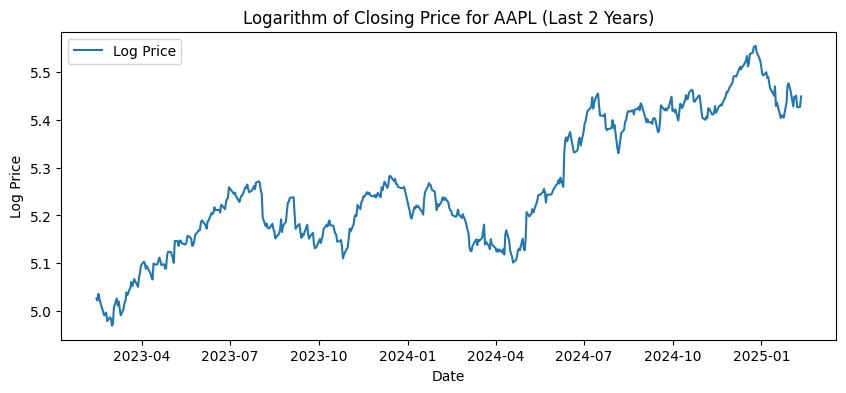

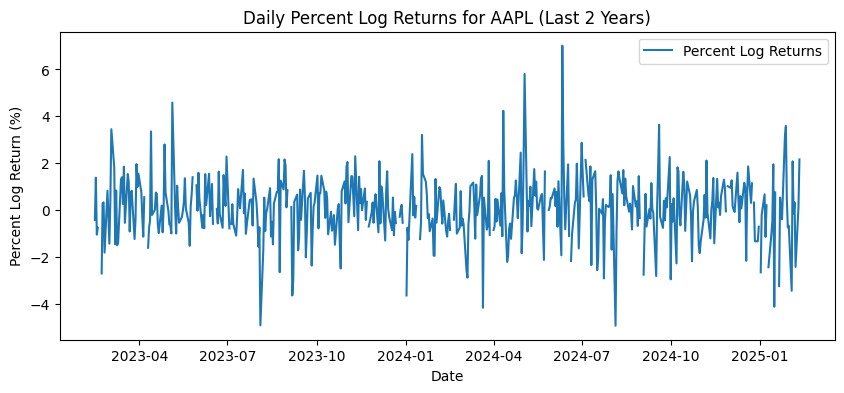

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     Percent_Log_Return   No. Observations:                  521
Model:               ARIMA(20, 0, 20)   Log Likelihood                -840.410
Date:                Wed, 12 Feb 2025   AIC                           1764.819
Time:                        16:11:11   BIC                           1943.561
Sample:                    02-14-2023   HQIC                          1834.833
                         - 02-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0705      0.064      1.098      0.272      -0.055       0.196
ar.L1          0.3124      7.467      0.042      0.967     -14.323      14.948
ar.L2          0.0573      6.469      0.009      0.9

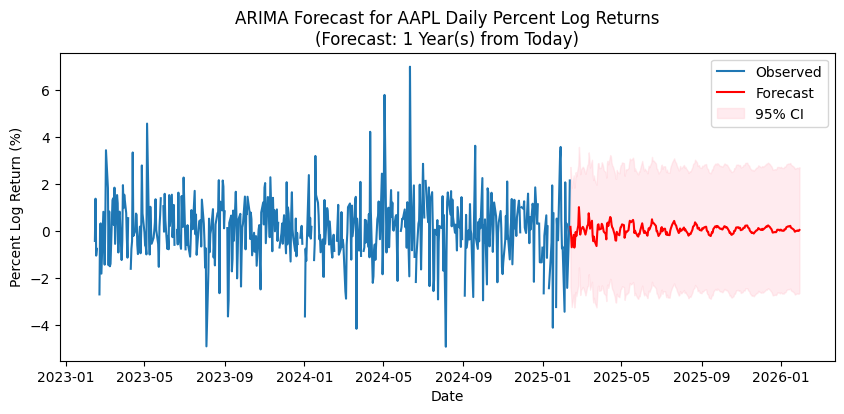

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -828.834
Distribution:                  Normal   AIC:                           1701.67
Method:            Maximum Likelihood   BIC:                           1794.39
                                        No. Observations:                  500
Date:                Wed, Feb 12 2025   Df Residuals:                      499
Time:                        16:11:12   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0166  8.168e-02     -0.204      0.839 [ -0.177,  0.14

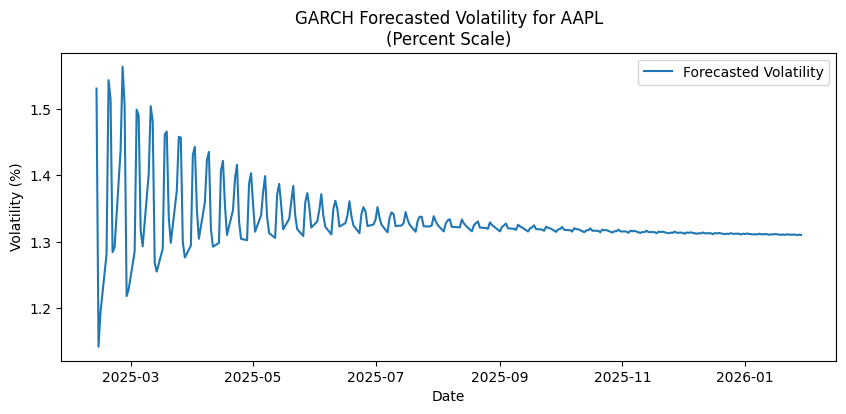

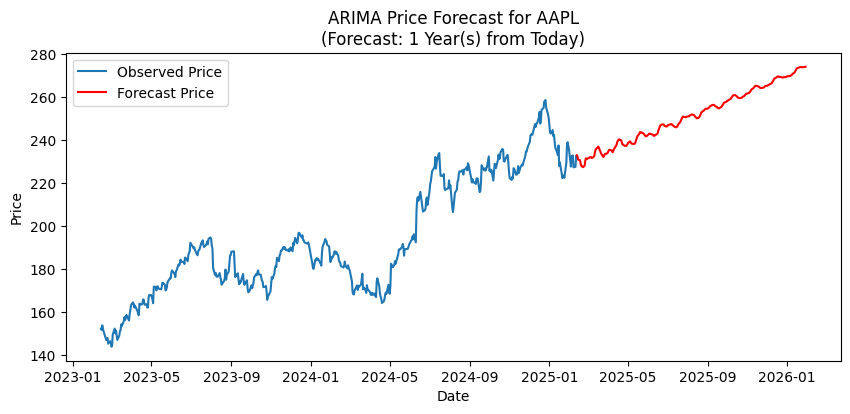

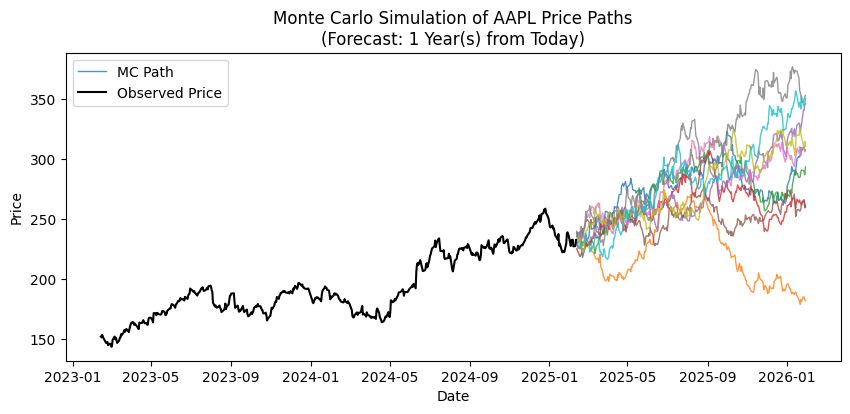

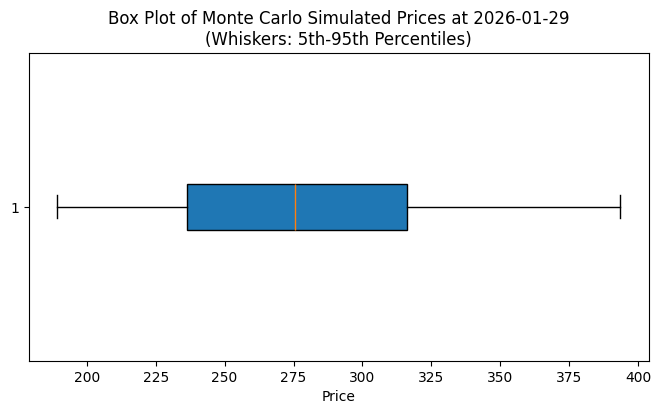

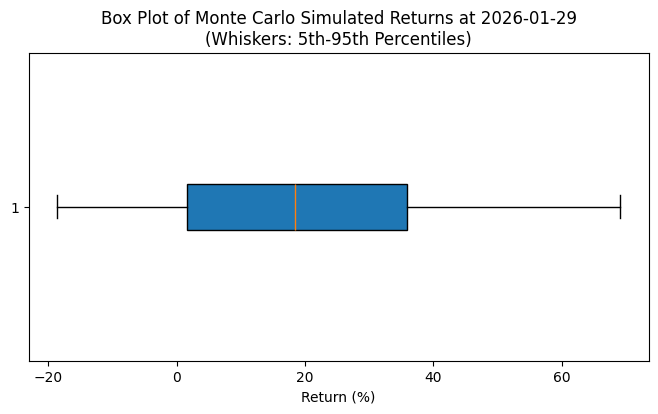

Value at Risk (95% confidence level): -18.71%
Expected Shortfall (95% confidence level): -25.61%
Probability of Profit (Final Price > Current Price): 77.60%


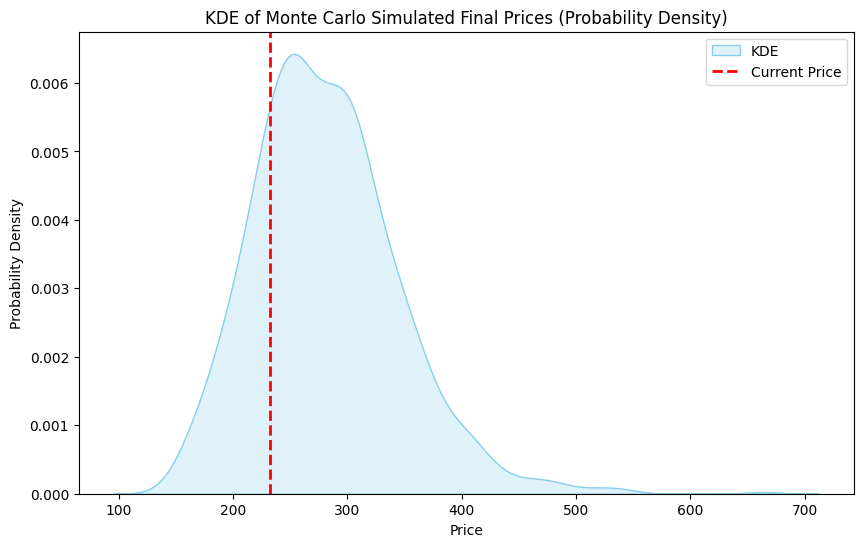

Current price is at the 22.40th percentile of the final simulated prices.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model  # pip install arch
from scipy.stats import percentileofscore, probplot
import seaborn as sns

# =============================================================================
# PARAMETERS (All parameters are defined at the beginning)
# =============================================================================

# Data parameters
ticker = 'AAPL'
data_years = 2      # Number of previous years of data to use as input
forecast_years = 1  # Forecast horizon in years

# Compute dates based on parameters
end_date = pd.Timestamp.today().normalize()  # Today's date (normalized)
start_date = end_date - pd.DateOffset(years=data_years)

frequency = 'B'  # Business day frequency

# ARIMA model parameters (applied to percent log returns)
arima_order = (20, 0, 20)

# Forecasting parameters
forecast_steps = 252 * forecast_years  # Approximate number of business days in forecast_years

# GARCH model parameters (applied to ARIMA residuals)
garch_p = 10
garch_q = 10
garch_distribution = 'normal'

# Monte Carlo simulation parameters
num_paths = 1000     # Number of Monte Carlo simulation paths to generate
paths_to_plot = 10   # Number of simulation paths to display in the plot

# =============================================================================
# DATA DOWNLOAD AND PREPARATION
# =============================================================================

# Download historical data from start_date to end_date
data = yf.download(ticker, start=start_date, end=end_date)

# Compute the logarithm of the closing price
data['Log_Price'] = np.log(data['Close'])

plt.figure(figsize=(10, 4))
plt.plot(data['Log_Price'], label='Log Price')
plt.title(f'Logarithm of Closing Price for {ticker} (Last {data_years} Years)')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.legend()
plt.show()

# Calculate the daily logarithmic return and rescale by multiplying by 100.
# Percent_Log_Return = 100 * log(Close_t / Close_{t-1})
data['Percent_Log_Return'] = 100 * np.log(data['Close'] / data['Close'].shift(1))
percent_returns = data['Percent_Log_Return'].dropna()

# Ensure the index is a DateTimeIndex and set the frequency.
percent_returns.index = pd.to_datetime(percent_returns.index)
percent_returns = percent_returns.asfreq(frequency)

plt.figure(figsize=(10, 4))
plt.plot(percent_returns, label='Percent Log Returns')
plt.title(f'Daily Percent Log Returns for {ticker} (Last {data_years} Years)')
plt.xlabel('Date')
plt.ylabel('Percent Log Return (%)')
plt.legend()
plt.show()

# =============================================================================
# ARIMA MODELING AND FORECASTING OF PERCENT LOG RETURNS (WITH CONFIDENCE INTERVAL)
# =============================================================================

# Fit the ARIMA model on the percent log returns.
model = ARIMA(percent_returns, order=arima_order)
model_fit = model.fit()
print(model_fit.summary())

# Forecast percent log returns using ARIMA.
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# Create a date range for the forecast period (forecast_years from today)
forecast_index = pd.date_range(start=percent_returns.index[-1] + pd.Timedelta(days=1),
                               periods=forecast_steps, freq=frequency)
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

plt.figure(figsize=(10, 4))
plt.plot(percent_returns, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')
plt.title(f'ARIMA Forecast for {ticker} Daily Percent Log Returns\n(Forecast: {forecast_years} Year(s) from Today)')
plt.xlabel('Date')
plt.ylabel('Percent Log Return (%)')
plt.legend()
plt.show()

# =============================================================================
# GARCH ON ARIMA RESIDUALS
# =============================================================================

# Extract ARIMA model residuals and fit a GARCH(1,1) model.
arima_resid = model_fit.resid.dropna()
garch_model = arch_model(arima_resid, vol='Garch', p=garch_p, q=garch_q, dist=garch_distribution)
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

# Forecast the conditional variance (volatility) for the next forecast_steps.
garch_forecast = garch_fit.forecast(horizon=forecast_steps)
# Use the last available variance forecast.
forecast_variance = garch_forecast.variance.iloc[-1]
forecast_volatility = np.sqrt(forecast_variance)
forecast_volatility.index = forecast_index

plt.figure(figsize=(10, 4))
plt.plot(forecast_volatility, label='Forecasted Volatility')
plt.title(f'GARCH Forecasted Volatility for {ticker}\n(Percent Scale)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.show()

# =============================================================================
# PRICE FORECAST FROM PERCENT LOG RETURN FORECAST WITH 2x VOLATILITY EFFECT
# =============================================================================

# Get the last observed log price.
last_log_price = data['Log_Price'].iloc[-1]

# IMPORTANT: The ARIMA forecast is in percent; to convert to standard log returns, divide by 100.
forecast_log_price = last_log_price + np.cumsum(forecast_mean / 100)

# For the envelope, add/subtract 2 times the forecasted volatility (in percent) then divide by 100.
forecast_log_price_up = last_log_price + np.cumsum((forecast_mean + 2 * forecast_volatility) / 100)
forecast_log_price_down = last_log_price + np.cumsum((forecast_mean - 2 * forecast_volatility) / 100)

# Convert forecasted log prices back to the original price scale.
forecast_price = np.exp(forecast_log_price)
forecast_price_up = np.exp(forecast_log_price_up)
forecast_price_down = np.exp(forecast_log_price_down)

plt.figure(figsize=(10, 4))
plt.plot(data['Close'], label='Observed Price')
plt.plot(forecast_index, forecast_price, label='Forecast Price', color='red')
#plt.fill_between(forecast_index,
#                 forecast_price_down,
#                 forecast_price_up,
#                 color='pink', alpha=0.3, label='±2x Volatility Envelope')
plt.title(f'ARIMA Price Forecast for {ticker}\n(Forecast: {forecast_years} Year(s) from Today)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# =============================================================================
# MONTE CARLO SIMULATION OF PRICE PATHS
# =============================================================================

# Generate Monte Carlo simulation paths using the forecasted percent log returns and volatility.
# For each forecast step, the simulated percent log return is:
#   simulated_return = forecast_mean[t] + forecast_volatility[t] * Z, where Z ~ N(0,1)
# Convert these percent returns back to standard log returns (divide by 100) when cumulatively summing.
simulated_paths = pd.DataFrame(index=forecast_index, columns=range(num_paths))

for path in range(num_paths):
    simulated_log_prices = []
    current_log_price = last_log_price
    for t in range(forecast_steps):
        mu = forecast_mean.iloc[t]         # in percent
        sigma = forecast_volatility.iloc[t]  # in percent
        shock = mu + sigma * np.random.randn()
        current_log_price += shock / 100    # convert percent to standard log return
        simulated_log_prices.append(current_log_price)
    simulated_paths[path] = np.exp(simulated_log_prices)

# For plotting, randomly select a subset of simulation paths.
np.random.seed(42)  # For reproducibility.
selected_paths = np.random.choice(simulated_paths.columns, paths_to_plot, replace=False)

plt.figure(figsize=(10, 4))
for path in selected_paths:
    plt.plot(simulated_paths.index, simulated_paths[path], lw=1, alpha=0.8,
             label='MC Path' if path == selected_paths[0] else None)
plt.plot(data['Close'], label='Observed Price', color='black')
plt.title(f'Monte Carlo Simulation of {ticker} Price Paths\n(Forecast: {forecast_years} Year(s) from Today)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# =============================================================================
# BOX PLOT OF MONTE CARLO SIMULATED PRICES AT THE FORECAST HORIZON
# =============================================================================

# Extract the final simulated prices from the last forecast date.
final_prices = simulated_paths.iloc[-1]

plt.figure(figsize=(8, 4))
plt.boxplot(final_prices, vert=False, patch_artist=True, whis=(5, 95), showfliers=False)
plt.xlabel('Price')
plt.title(f'Box Plot of Monte Carlo Simulated Prices at {forecast_index[-1].date()}\n(Whiskers: 5th-95th Percentiles)')
plt.show()

# =============================================================================
# BOX PLOT OF MONTE CARLO SIMULATED RETURNS AT THE FORECAST HORIZON
# =============================================================================

# Calculate simulated returns in percent, defined as:
#   100 * (Final Price - Current Price) / Current Price
current_price = data['Close'].iloc[-1].values[0]
simulated_returns = 100 * (final_prices - current_price) / current_price

plt.figure(figsize=(8, 4))
plt.boxplot([simulated_returns.values], vert=False, patch_artist=True, whis=(5, 95), showfliers=False)
plt.xlabel('Return (%)')
plt.title(f'Box Plot of Monte Carlo Simulated Returns at {forecast_index[-1].date()}\n(Whiskers: 5th-95th Percentiles)')
plt.show()

# =============================================================================
# RISK METRICS: VALUE AT RISK (VaR) AND EXPECTED SHORTFALL (ES)
# =============================================================================

# For the simulated returns (in percent), compute the Value at Risk (VaR) and Expected Shortfall (ES)
# at a 95% confidence level. Here, VaR is the 5th percentile of the simulated returns.
confidence_level = 0.95
alpha = 1 - confidence_level  # 0.05
var_threshold = np.percentile(simulated_returns, 100 * alpha)  # 5th percentile
expected_shortfall = simulated_returns[simulated_returns <= var_threshold].mean()

print(f"Value at Risk (95% confidence level): {var_threshold:.2f}%")
print(f"Expected Shortfall (95% confidence level): {expected_shortfall:.2f}%")

# =============================================================================
# PROBABILITY OF PROFIT FROM MONTE CARLO SIMULATION
# =============================================================================

# Calculate the probability of profit as the percentage of simulated final prices
# that exceed the current (latest) price.
prob_profit = np.mean(final_prices > current_price) * 100
print(f"Probability of Profit (Final Price > Current Price): {prob_profit:.2f}%")

plt.figure(figsize=(10, 6))
sns.kdeplot(final_prices, fill=True, color='skyblue', label='KDE')
plt.axvline(current_price, color='red', linestyle='dashed', linewidth=2, label='Current Price')
plt.title('KDE of Monte Carlo Simulated Final Prices (Probability Density)')
plt.xlabel('Price')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# =============================================================================
# FIND PERCENTILE OF CURRENT PRICE AT THE END OF SIMULATION
# =============================================================================

current_price_percentile = percentileofscore(final_prices, current_price)
print(f"Current price is at the {current_price_percentile:.2f}th percentile of the final simulated prices.")
